Task 1 : CNN Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 28.7 MB/s 


In [3]:
# Untar the file
import tarfile
tar = tarfile.open("UTKFace.tar.gz")
tar.extractall()
tar.close()

In [4]:
# map gender,race
dirpath = "UTKFace"
dic_gender = {0: 'male', 1: 'female'}
dic_gender_map = dict((g, i) for i, g in dic_gender.items())
dic_race = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
dic_race_map = dict((r, i) for i, r in dic_race.items())

dic_gender, dic_race

({0: 'male', 1: 'female'},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'})

In [5]:
# read file and split attributes
def read_file(fpath):
    try:
        path, fname = os.path.split(fpath)
        fname, ext = os.path.splitext(fname)
        age, gender, race, _ = fname.split("_")
        return int(age), dic_gender[int(gender)], dic_race[int(race)]
    except Exception as e:
        print(fpath)
        return None, None, None

In [6]:
# Create a data frame of age,gender,race and filename
filelist = glob.glob(os.path.join(dirpath, "*.jpg"))

In [7]:
features = list(map(read_file, filelist))

UTKFace/39_1_20170116174525125.jpg.chip.jpg
UTKFace/61_1_20170109142408075.jpg.chip.jpg
UTKFace/61_1_20170109150557335.jpg.chip.jpg


In [8]:
df = pd.DataFrame(features)
df['file'] = filelist
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,80.0,female,black,UTKFace/80_1_1_20170119210040345.jpg.chip.jpg
1,37.0,male,white,UTKFace/37_0_0_20170117114931801.jpg.chip.jpg
2,46.0,male,white,UTKFace/46_0_0_20170119204805959.jpg.chip.jpg
3,52.0,male,white,UTKFace/52_0_0_20170113183752750.jpg.chip.jpg
4,80.0,female,white,UTKFace/80_1_0_20170110141723527.jpg.chip.jpg


In [9]:
perm1 = np.random.permutation(len(df))
split_ratio = 0.7
image_width = image_height = 198
train_ = int(len(df) * split_ratio)
train_data = perm1[:train_]
test_data = perm1[train_:]

# split train_data further into training and validation set
train_ = int(train_ * 0.7)
train_data, valid_data = train_data[:train_], train_data[train_:]

df['gender_id'] = df['gender'].map(lambda gender: dic_gender_map[gender])
df['race_id'] = df['race'].map(lambda race: dic_race_map[race])

max_age = df['age'].max()
len(train_data), len(valid_data), len(test_data), max_age

(11615, 4978, 7112, 116.0)

In [10]:
from keras.utils.np_utils import to_categorical
from PIL import Image
batch_size = 32
def get_data(df, index, training, batch_size):
    images = []
    ages = []
    races = []
    genders = []
    while True:
        for i in index:
            raw = df.iloc[i]
            file = raw['file'] 
            age = raw['age']
            race = raw['race_id']
            gender = raw['gender_id']
            im = Image.open(file)
            im = im.resize((image_width, image_height))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(dic_race_map)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images = []
                ages = []
                races = []
                genders = []
        if not training:
            break

In [11]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    x = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D()(x)
    return x

input_layer = Input(shape=(image_height, image_width, 3))
x = conv_block(input_layer, filters=32, bn=False, pool=False)
x = conv_block(x, filters=64)
x = conv_block(x, filters=128)
x = conv_block(x, filters=256)
x = conv_block(x, filters=512)
x = conv_block(x, filters=728)
bneck = GlobalMaxPool2D()(x)

# age prediction
x = Dense(units=128, activation='relu')(bneck)
age_predict = Dense(units=1, activation='sigmoid', name='age_output')(x)

# race prediction
x = Dense(units=128, activation='relu')(bneck)
race_predict = Dense(units=len(dic_race_map), activation='softmax', name='race_output')(x)

# gender prediction
x = Dense(units=128, activation='relu')(bneck)
gender_predict = Dense(units=len(dic_gender_map), activation='softmax', name='gender_output')(x)

model = Model(inputs=input_layer, outputs=[age_predict, race_predict, gender_predict])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()


In [12]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data(df, train_data, training=True, batch_size=batch_size)
valid_gen = get_data(df, valid_data, training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_data)//batch_size,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_data)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
181/181 [==============================] - 95s 410ms/step - loss: 3.2811 - age_output_loss: 0.0882 - race_output_loss: 1.5328 - gender_output_loss: 0.8055 - age_output_mae: 0.2421 - race_output_accuracy: 0.4738 - gender_output_accuracy: 0.6444 - val_loss: 3.2875 - val_age_output_loss: 0.0387 - val_race_output_loss: 1.6005 - val_gender_output_loss: 0.8094 - val_age_output_mae: 0.1493 - val_race_output_accuracy: 0.3287 - val_gender_output_accuracy: 0.5325
Epoch 2/10
181/181 [==============================] - 72s 396ms/step - loss: 1.8844 - age_output_loss: 0.0268 - race_output_loss: 0.9485 - gender_output_loss: 0.4080 - age_output_mae: 0.1267 - race_output_accuracy: 0.6533 - gender_output_accuracy: 0.8128 - val_loss: 2.2221 - val_age_output_loss: 0.0243 - val_race_output_loss: 1.1353 - val_gender_output_loss: 0.4706 - val_age_output_mae: 0.1276 - val_race_output_accuracy: 0.5722 - val_gender_output_accuracy: 0.7573
Epoch 3/10
181/181 [==============================] - 73s 404m

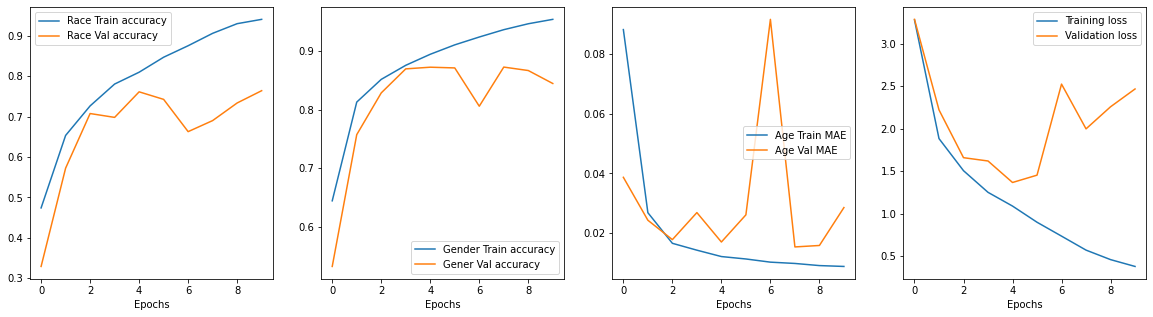

In [13]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

Evaluation

In [14]:
test_gen = get_data(df, test_data, training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_data)//128)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


{'age_output_loss': 0.02873079851269722,
 'age_output_mae': 0.13546772301197052,
 'gender_output_accuracy': 0.8450284004211426,
 'gender_output_loss': 0.5600089430809021,
 'loss': 2.286365032196045,
 'race_output_accuracy': 0.7752841114997864,
 'race_output_loss': 1.1125963926315308}

In [15]:
test_gen = get_data(df, test_data, training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [16]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [17]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.74      0.91      0.81        55
           1       0.73      0.90      0.81        21
           2       0.89      0.89      0.89        18
           3       0.94      0.68      0.79        22
           4       0.00      0.00      0.00        12

    accuracy                           0.78       128
   macro avg       0.66      0.68      0.66       128
weighted avg       0.72      0.78      0.74       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        71
           1       0.93      0.70      0.80        57

    accuracy                           0.84       128
   macro avg       0.87      0.83      0.84       128
weighted avg       0.86      0.84      0.84       128



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


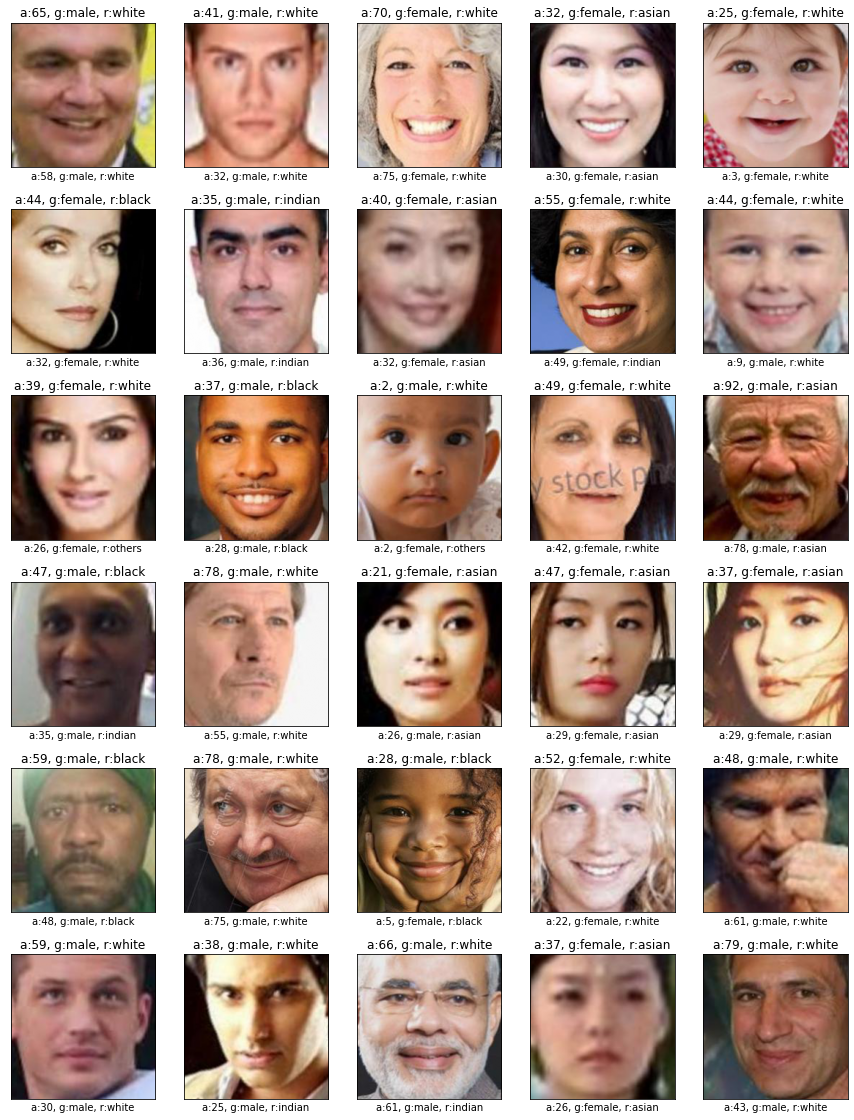

In [18]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), dic_gender[gender_pred[img_idx]], dic_race[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), dic_gender[gender_true[img_idx]], dic_race[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])